In [1]:
%pip install matplotlib
%pip install pandas
%pip install seaborn

import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.ticker import FuncFormatter

# Suppress the specific DeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning)

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Note: you may need to restart the kernel to use updated packages.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
input_commune_parquet_file_path = '../data/interm/4.0_commune.parquet'
input_syndicat_parquet_file_path = '../data/interm/4.0_syndicat.parquet'

In [3]:
code_insee_identifier = 'Clean code INSEE'

num_top_taxes = 3

commune_data_df = pd.read_parquet(input_commune_parquet_file_path)
syndicate_data_df = pd.read_parquet(input_syndicat_parquet_file_path)

commune_tax_columns = commune_data_df.columns[8:]
syndicate_tax_columns = syndicate_data_df.columns[8:]

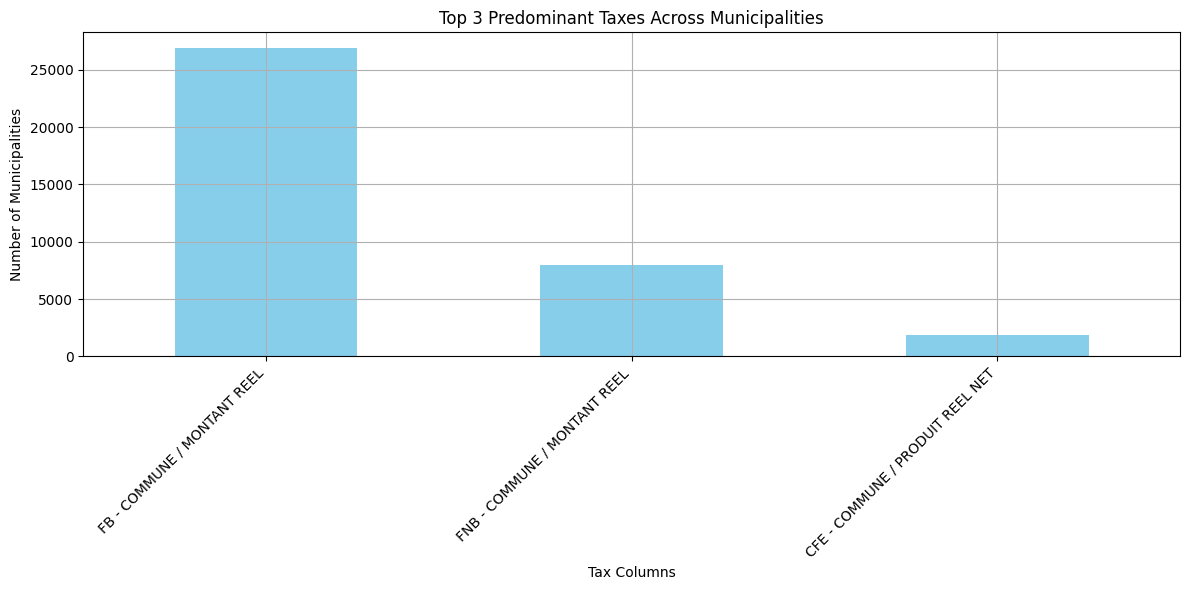

Total number of municipalities: 36746
Top predominant taxes overall: ['FB - COMMUNE / MONTANT REEL', 'FNB - COMMUNE / MONTANT REEL', 'CFE - COMMUNE / PRODUIT REEL NET']
Number of communes with top predominant tax 'FB - COMMUNE / MONTANT REEL': 26911
Number of communes with top predominant tax 'FNB - COMMUNE / MONTANT REEL': 7953
Number of communes with top predominant tax 'CFE - COMMUNE / PRODUIT REEL NET': 1866
Top taxes for municipalities that do not match any of the top 3 predominant taxes:
                                       Top_Tax
Clean code INSEE                              
29083                    IFER TOTALE / COMMUNE
97358             CFE - TSE / PRODUIT REEL NET


In [4]:
# Calculate the sum for each tax-related column per commune
commune_tax_sums = commune_data_df.groupby(code_insee_identifier)[commune_tax_columns].sum()

# Identify the top predominant taxes overall
predominant_tax_counts = commune_tax_sums[commune_tax_columns].idxmax(axis=1).value_counts()
top_predominant_taxes = predominant_tax_counts.head(num_top_taxes).index.tolist()

# Function to check if the top taxes for a municipality match any of the overall top taxes
def check_top_taxes(row, top_predominant_taxes, num_top_taxes):
    top_taxes = row.nlargest(num_top_taxes).index.tolist()
    return any(tax in top_predominant_taxes for tax in top_taxes)

# Check for each municipality if the top taxes match any of the overall top taxes
commune_tax_sums['Top_Tax_Match'] = commune_tax_sums[commune_tax_columns].apply(check_top_taxes, top_predominant_taxes=top_predominant_taxes, num_top_taxes=num_top_taxes, axis=1)

# Count how many municipalities have the same top predominant taxes
matching_municipalities_count = commune_tax_sums['Top_Tax_Match'].sum()
total_municipalities_count = commune_tax_sums.shape[0]

# Plot the results for the top predominant taxes
plt.figure(figsize=(12, 6))
predominant_tax_counts.head(num_top_taxes).plot(kind='bar', color='skyblue')

plt.title(f'Top {num_top_taxes} Predominant Taxes Across Municipalities')
plt.xlabel('Tax Columns')
plt.ylabel('Number of Municipalities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

# Output the results
print(f"Total number of municipalities: {total_municipalities_count}")
print(f"Top predominant taxes overall: {top_predominant_taxes}")

for tax in top_predominant_taxes:
    count = (commune_tax_sums[commune_tax_columns].idxmax(axis=1) == tax).sum()
    print(f"Number of communes with top predominant tax '{tax}': {count}")

# Display the top taxes for municipalities that do not match any of the overall top predominant taxes
non_matching_municipalities = commune_tax_sums.loc[~commune_tax_sums['Top_Tax_Match']].copy()
non_matching_municipalities.loc[:, 'Top_Tax'] = non_matching_municipalities[commune_tax_columns].idxmax(axis=1)

print(f"Top taxes for municipalities that do not match any of the top {num_top_taxes} predominant taxes:")
print(non_matching_municipalities[['Top_Tax']].head(10))  # Display the first 10 for brevity


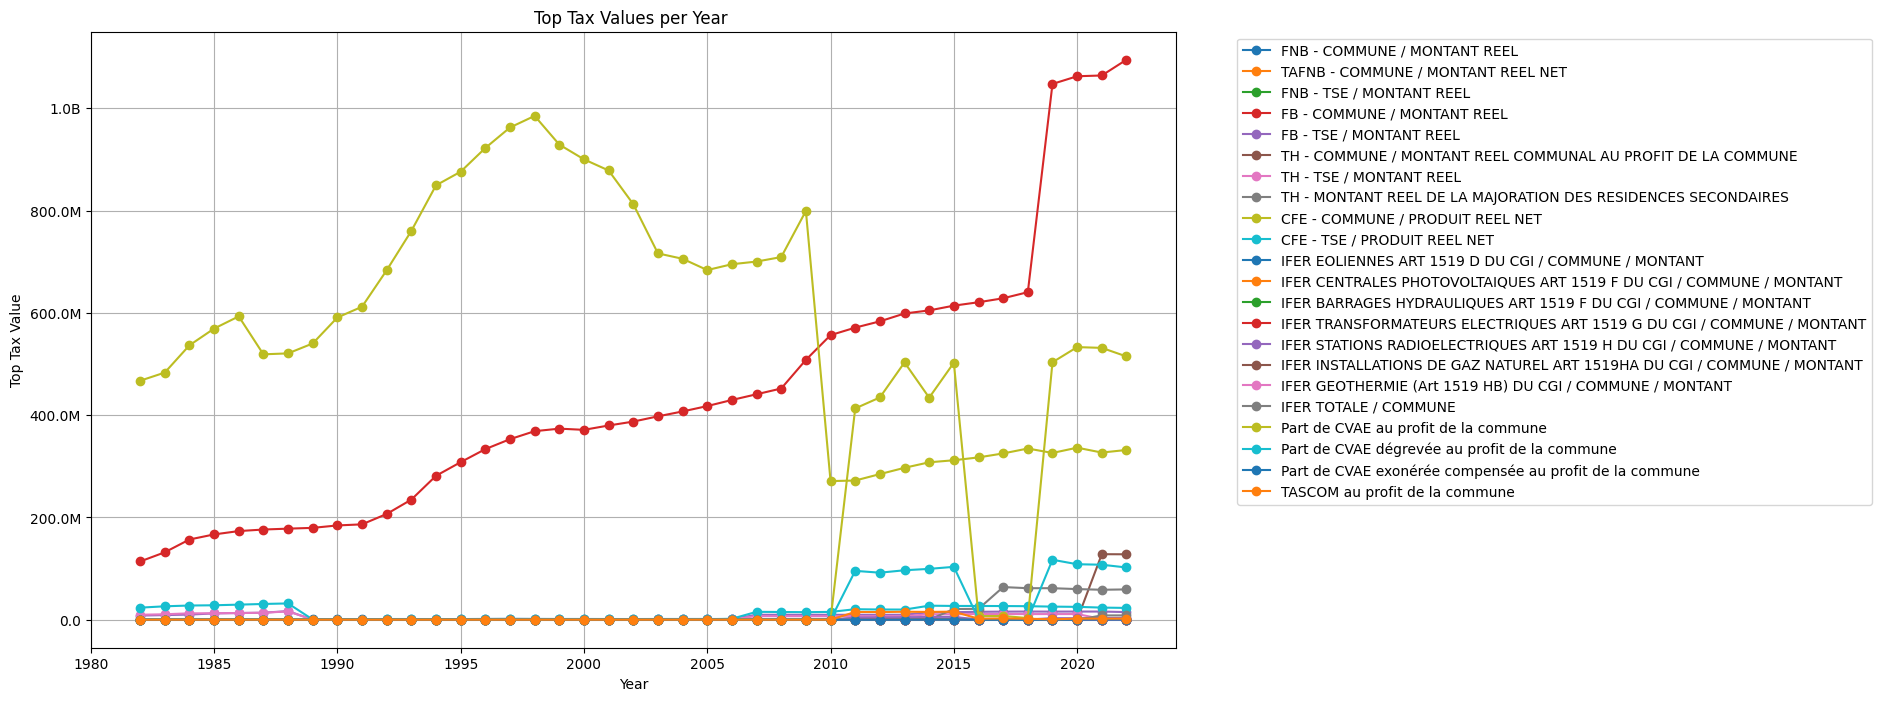

In [5]:
def human_readable_format(x, pos=None):
    """
    Converts a number into a human-readable format (K, M, B, T).
    
    Parameters:
    x (float): The number to be converted.
    pos (optional): The position (not used, but required for compatibility with matplotlib).

    Returns:
    str: The human-readable format of the number.
    """
    if x >= 1e12:
        return f'{x / 1e12:.1f}T'
    elif x >= 1e9:
        return f'{x / 1e9:.1f}B'
    elif x >= 1e6:
        return f'{x / 1e6:.1f}M'
    elif x >= 1e3:
        return f'{x / 1e3:.1f}K'
    else:
        return str(x)
    
# Grouping by year and finding the maximum tax value for each year
top_taxes = commune_data_df.groupby('ANNEE')[commune_tax_columns].max().reset_index()

# Converting columns to numeric where possible to ensure proper comparison
top_taxes[commune_tax_columns] = top_taxes[commune_tax_columns].apply(pd.to_numeric, errors='coerce')

# Filtering out columns with all zero values
non_zero_tax_columns = [col for col in commune_tax_columns if top_taxes[col].sum() > 0]

# Plotting the results with labels only in the legend and removing point labels
plt.figure(figsize=(14, 8))
for column in non_zero_tax_columns:
    plt.plot(top_taxes['ANNEE'], top_taxes[column], label=column, marker='o')

plt.xlabel('Year')
plt.ylabel('Top Tax Value')
plt.title('Top Tax Values per Year ')
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

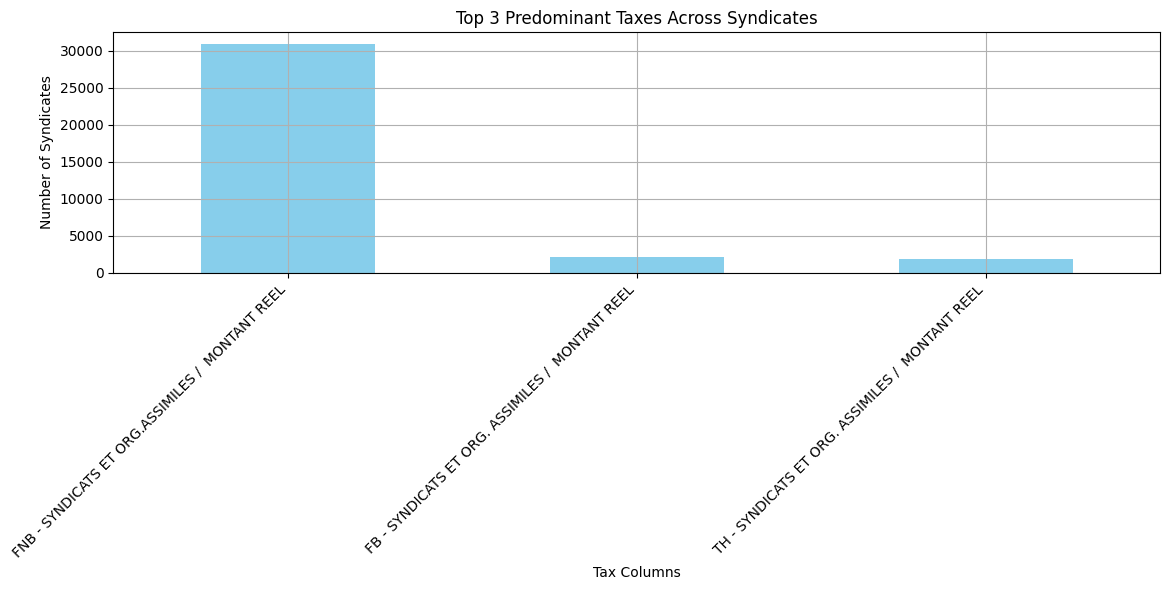

Total number of syndicates: 36746
Top predominant taxes overall: ['FNB - SYNDICATS ET ORG.ASSIMILES /  MONTANT REEL', 'FB - SYNDICATS ET ORG. ASSIMILES /  MONTANT REEL', 'TH - SYNDICATS ET ORG. ASSIMILES /  MONTANT REEL']
Number of syndicates with top predominant tax 'FNB - SYNDICATS ET ORG.ASSIMILES /  MONTANT REEL': 30931
Number of syndicates with top predominant tax 'FB - SYNDICATS ET ORG. ASSIMILES /  MONTANT REEL': 2102
Number of syndicates with top predominant tax 'TH - SYNDICATS ET ORG. ASSIMILES /  MONTANT REEL': 1879
Top taxes for syndicates that do not match any of the top 3 predominant taxes:
Empty DataFrame
Columns: [Top_Tax]
Index: []


In [6]:
# Calculate the sum for each tax-related column per syndicate
syndicate_tax_sums = syndicate_data_df.groupby(code_insee_identifier)[syndicate_tax_columns].sum()

# Identify the top predominant taxes overall
predominant_tax_counts = syndicate_tax_sums[syndicate_tax_columns].idxmax(axis=1).value_counts()
top_predominant_taxes = predominant_tax_counts.head(num_top_taxes).index.tolist()

# Function to check if the top taxes for a syndicate match any of the overall top taxes
def check_top_taxes(row, top_predominant_taxes, num_top_taxes):
    top_taxes = row.nlargest(num_top_taxes).index.tolist()
    return any(tax in top_predominant_taxes for tax in top_taxes)

# Check for each syndicate if the top taxes match any of the overall top taxes
syndicate_tax_sums['Top_Tax_Match'] = syndicate_tax_sums[syndicate_tax_columns].apply(check_top_taxes, top_predominant_taxes=top_predominant_taxes, num_top_taxes=num_top_taxes, axis=1)

# Count how many syndicates have the same top predominant taxes
matching_syndicates_count = syndicate_tax_sums['Top_Tax_Match'].sum()
total_syndicates_count = syndicate_tax_sums.shape[0]

# Plot the results for the top predominant taxes
plt.figure(figsize=(12, 6))
predominant_tax_counts.head(num_top_taxes).plot(kind='bar', color='skyblue')

plt.title(f'Top {num_top_taxes} Predominant Taxes Across Syndicates')
plt.xlabel('Tax Columns')
plt.ylabel('Number of Syndicates')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

# Output the results
print(f"Total number of syndicates: {total_syndicates_count}")
print(f"Top predominant taxes overall: {top_predominant_taxes}")

for tax in top_predominant_taxes:
    count = (syndicate_tax_sums[syndicate_tax_columns].idxmax(axis=1) == tax).sum()
    print(f"Number of syndicates with top predominant tax '{tax}': {count}")

# Display the top taxes for syndicates that do not match any of the overall top predominant taxes
non_matching_syndicates = syndicate_tax_sums.loc[~syndicate_tax_sums['Top_Tax_Match']].copy()
non_matching_syndicates['Top_Tax'] = non_matching_syndicates[syndicate_tax_columns].idxmax(axis=1)

print(f"Top taxes for syndicates that do not match any of the top {num_top_taxes} predominant taxes:")
print(non_matching_syndicates[['Top_Tax']].head(10))  # Display the first 10 for brevity


In [7]:
del commune_data_df
del syndicate_data_df

gc.collect()

11052